# Identifying Early Signals of Long-Term Subscription

## Executive Summary
This notebook analyzes early-stage customer behavior in a fictional multi-table SaaS dataset (RavenStack) to identify signals associated with early churn versus long-term retention.  
Key findings suggest that early usage volume alone provides limited explanatory power, while early support friction (e.g., escalations and longer resolution times) is more actionable.  
The notebook concludes with an interpretable risk-scoring framework designed to prioritize proactive retention interventions.

## Objective
Identify early-stage customer behavior patterns (within the first 30 days) that help distinguish long-term subscribers from early churners in a subscription-based SaaS product.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

accounts = pd.read_csv('ravenstack_accounts.csv')
subscriptions = pd.read_csv('ravenstack_subscriptions.csv')
feature_usage = pd.read_csv('ravenstack_feature_usage.csv')
support = pd.read_csv('ravenstack_support_tickets.csv')
churn = pd.read_csv('ravenstack_churn_events.csv')

In [36]:
accounts['signup_date'] = pd.to_datetime(accounts['signup_date'])

subscriptions['start_date'] = pd.to_datetime(subscriptions['start_date'])
subscriptions['end_date'] = pd.to_datetime(subscriptions['end_date'])

feature_usage['usage_date'] = pd.to_datetime(feature_usage['usage_date'])

support['submitted_at'] = pd.to_datetime(support['submitted_at'])
support['closed_at'] = pd.to_datetime(support['closed_at'])

churn['churn_date'] = pd.to_datetime(churn['churn_date'])


In [38]:
df = accounts.merge(subscriptions, on = 'account_id', how = 'left', suffixes = ('_account', '_sub'))
df.head()

,account_id,account_name,industry,country,signup_date,referral_source,plan_tier_account,seats_account,is_trial_account,churn_flag_account,...,plan_tier_sub,seats_sub,mrr_amount,arr_amount,is_trial_sub,upgrade_flag,downgrade_flag,churn_flag_sub,billing_frequency,auto_renew_flag
0,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False,...,Basic,11,209,2508,False,False,False,False,monthly,True
1,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False,...,Pro,20,980,11760,False,False,False,False,monthly,True
2,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False,...,Pro,9,441,5292,False,False,False,False,monthly,True
3,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False,...,Enterprise,9,1791,21492,False,False,False,False,annual,False
4,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False,...,Basic,102,1938,23256,False,False,False,False,monthly,True


In [4]:
today = pd.Timestamp.today().normalize()

df['effective_end_date'] = df['end_date'].fillna(today)
df['subscription_length_days'] = (df['effective_end_date']-df['start_date']).dt.days

df[['account_id', 'start_date', 'end_date', 'effective_end_date', 'subscription_length_days']].head()

,account_id,start_date,end_date,effective_end_date,subscription_length_days
0,A-2e4581,2024-12-09,NaT,2025-12-28,384
1,A-2e4581,2024-11-12,NaT,2025-12-28,411
2,A-2e4581,2024-10-20,NaT,2025-12-28,434
3,A-2e4581,2024-11-29,NaT,2025-12-28,394
4,A-2e4581,2024-11-13,NaT,2025-12-28,410


## Defining Customer Outcomes

To identify early signals of retention and churn, customers were first segmented based on subscription duration.

- **Early Churn**: Subscriptions ending within 90 days  
- **Long-Term**: Subscriptions lasting 180 days or longer  
- **Mid-Term**: Intermediate cases (excluded from primary analysis)

This outcome-based segmentation allows for a clear comparison between customers who quickly disengaged and those who demonstrated sustained product adoption.

In [5]:
def label_customer(row):
    if row['subscription_length_days'] <= 90:
        return 'Early Churn'
    elif row['subscription_length_days'] >= 180:
        return 'Long-Term'
    else:
        return 'Mid-Term'

df['customer_group'] = df.apply(label_customer, axis = 1)
df['customer_group'].value_counts(dropna = False)

customer_group
Long-Term      4593
Early Churn     330
Mid-Term         77
Name: count, dtype: int64

## Defining the Early Usage Window

Early-stage behavior is defined as customer activity occurring within the first **30 days after signup**.

This early window is critical, as it represents the period during which users form their initial understanding of the product’s value and usability. The analysis focuses exclusively on this window to identify signals that precede long-term retention or early churn.

In [39]:
df['early_end_date'] = df['signup_date'] + pd.Timedelta(days = 30)
df[['account_id', 'signup_date', 'early_end_date']].head()

,account_id,signup_date,early_end_date
0,A-2e4581,2024-10-16,2024-11-15
1,A-2e4581,2024-10-16,2024-11-15
2,A-2e4581,2024-10-16,2024-11-15
3,A-2e4581,2024-10-16,2024-11-15
4,A-2e4581,2024-10-16,2024-11-15


In [40]:
usage = feature_usage.merge(subscriptions[['subscription_id','account_id']], on = 'subscription_id', how = 'left')

usage = usage.merge(accounts[['account_id','signup_date']], on = 'account_id', how = 'left')

usage[['subscription_id','account_id']].isna().mean()
usage.head()

,usage_id,subscription_id,usage_date,feature_name,usage_count,usage_duration_secs,error_count,is_beta_feature,account_id,signup_date
0,U-1c6c24,S-0fcf7d,2023-07-27,feature_20,9,5004,0,False,A-e08cd3,2024-09-21
1,U-f07cb8,S-c25263,2023-08-07,feature_5,9,369,0,False,A-c7ffc2,2023-01-27
2,U-096807,S-f29e7f,2023-12-07,feature_3,9,1458,0,False,A-bbe56f,2023-02-16
3,U-6b1580,S-be655e,2024-07-28,feature_40,5,2085,0,False,A-7f29a7,2024-09-18
4,U-720a29,S-f9b1d0,2024-12-02,feature_12,12,900,0,False,A-65a46c,2023-11-04


In [8]:
usage_early = usage[(usage['usage_date'] >= usage['signup_date']) & (usage['usage_date'] <= usage['signup_date'] + pd.Timedelta(days = 30))].copy()
usage_early.head()

,usage_id,subscription_id,usage_date,feature_name,usage_count,usage_duration_secs,error_count,is_beta_feature,account_id,signup_date
115,U-0947d6,S-bcbe03,2024-10-04,feature_1,7,945,0,False,A-2789e3,2024-09-14
127,U-ded235,S-faa8ec,2024-10-29,feature_11,5,480,0,False,A-2e4581,2024-10-16
179,U-c67e37,S-2372d2,2024-04-09,feature_18,9,1296,3,False,A-cea1f0,2024-04-07
221,U-1e39f8,S-a9fb74,2023-12-29,feature_15,10,1370,2,False,A-c45b23,2023-12-08
322,U-c6d2b4,S-3c9a70,2023-05-13,feature_4,11,2002,1,False,A-ee42db,2023-04-25


In [9]:
early_usage_summary = usage_early.groupby('account_id').agg(total_usage_events = ('usage_id','count'), unique_features_used = ('feature_name','nunique'), used_beta_feature = ('is_beta_feature','max')).reset_index()

early_usage_summary.head()

,account_id,total_usage_events,unique_features_used,used_beta_feature
0,A-00bed1,3,3,False
1,A-00cac8,3,3,False
2,A-0158bb,1,1,False
3,A-019782,1,1,False
4,A-029f69,3,3,False


## Initial Early Usage Comparison

As a first step, basic early usage metrics were computed for each customer, including:

- Total number of usage events
- Number of unique features used
- Whether any beta features were used

These metrics provide a high-level view of early engagement volume and breadth.

In [10]:
df = df.merge(early_usage_summary, on = 'account_id', how = 'left')

df[['account_id', 'customer_group', 'total_usage_events', 'unique_features_used', 'used_beta_feature']].head()

,account_id,customer_group,total_usage_events,unique_features_used,used_beta_feature
0,A-2e4581,Long-Term,3.0,3.0,False
1,A-2e4581,Long-Term,3.0,3.0,False
2,A-2e4581,Long-Term,3.0,3.0,False
3,A-2e4581,Long-Term,3.0,3.0,False
4,A-2e4581,Long-Term,3.0,3.0,False


In [11]:
df.groupby('customer_group')[['total_usage_events', 'unique_features_used']].mean()

,total_usage_events,unique_features_used
customer_group,,
Early Churn,2.515358,2.474403
Long-Term,2.657797,2.597115
Mid-Term,2.569444,2.458333


## Observations from Basic Usage Metrics

The comparison of early usage volume reveals only **modest differences** between long-term subscribers and early churners.

While long-term customers exhibit slightly higher usage counts and feature diversity, the magnitude of these differences suggests that **raw activity volume alone is insufficient to clearly distinguish retention outcomes**.

This finding indicates that early signals of long-term subscription are likely driven not by how much users engage, but **how they engage**, motivating a deeper analysis of usage patterns and qualitative engagement signals.


## Moving Beyond Usage Volume

Initial results indicate that simple usage counts are insufficient to clearly separate long-term subscribers from early churners.

This section examines **early usage patterns**, focusing on engagement persistence and behavioral depth, to identify more informative early signals of retention.

In [12]:
active_days_summary = usage_early.groupby('account_id').agg(active_days_early = ('usage_date', 'nunique')).reset_index()

active_days_summary.head()

,account_id,active_days_early
0,A-00bed1,3
1,A-00cac8,3
2,A-0158bb,1
3,A-019782,1
4,A-029f69,3


In [13]:
if 'active_days_early' in df.columns:
    df = df.drop(columns=['active_days_early'])

df = df.merge(active_days_summary, on = 'account_id', how = 'left')
df[['account_id', 'customer_group', 'active_days_early']].head()

,account_id,customer_group,active_days_early
0,A-2e4581,Long-Term,3.0
1,A-2e4581,Long-Term,3.0
2,A-2e4581,Long-Term,3.0
3,A-2e4581,Long-Term,3.0
4,A-2e4581,Long-Term,3.0


In [14]:
df['avg_events_per_active_day'] = df['total_usage_events'] / df['active_days_early']

df[['total_usage_events','active_days_early','avg_events_per_active_day']]

,total_usage_events,active_days_early,avg_events_per_active_day
0,3.0,3.0,1.00
1,3.0,3.0,1.00
2,3.0,3.0,1.00
3,3.0,3.0,1.00
4,3.0,3.0,1.00
...,...,...,...
4995,5.0,4.0,1.25
4996,5.0,4.0,1.25
4997,5.0,4.0,1.25
4998,5.0,4.0,1.25


In [15]:
df.groupby('customer_group')[['active_days_early', 'avg_events_per_active_day', 'used_beta_feature']].mean()

,active_days_early,avg_events_per_active_day,used_beta_feature
customer_group,,,
Early Churn,2.436860,1.030660,0.273038
Long-Term,2.558319,1.038257,0.237006
Mid-Term,2.513889,1.023611,0.208333


## Interpretation: Limits of Usage-Based Signals

Although long-term subscribers display marginally higher early usage persistence, the differences are relatively small in magnitude. This suggests that early retention outcomes cannot be sufficiently explained by usage behavior alone.

This finding motivates a deeper investigation into **customer experience factors**, particularly early support interactions and friction points, which may play a more decisive role in driving churn.

## Examining Early Support Signals

Usage-based metrics show only limited ability to explain early churn, suggesting that customer experience factors may play a more decisive role.

This section examines **early support interactions** within the first 30 days after signup to assess whether support demand, severity, and resolution quality are associated with early churn outcomes.

In [16]:
support_early = support.merge(accounts[['account_id','signup_date']], on = ('account_id'), how = 'left')

support_early.head()

,ticket_id,account_id,submitted_at,closed_at,resolution_time_hours,priority,first_response_time_minutes,satisfaction_score,escalation_flag,signup_date
0,T-0024de,A-712f1c,2023-07-27,2023-07-28 03:00:00,27.0,high,74,NaN,False,2023-12-16
1,T-4d04b9,A-e43bf7,2024-07-08,2024-07-09 03:00:00,27.0,urgent,144,NaN,False,2023-03-24
2,T-d5e12f,A-0f3e88,2024-10-17,2024-10-17 19:00:00,19.0,urgent,93,4.0,False,2023-07-23
3,T-dfce9a,A-4c56c9,2024-09-08,2024-09-09 23:00:00,47.0,medium,126,5.0,False,2023-12-20
4,T-c59f77,A-6f8ad2,2024-11-30,2024-12-01 02:00:00,26.0,medium,8,NaN,False,2024-07-09


In [17]:
support_early = support_early[(support_early['submitted_at'] >= support_early['signup_date']) & (support_early['submitted_at'] <= support_early['signup_date'] + pd.Timedelta(days = 30))].copy()
support_early.shape

(87, 10)

In [18]:
early_support_summary = (
    support_early
        .groupby('account_id')
        .agg(
            early_support_tickets=('ticket_id','count'), 
            avg_resolution_time=('resolution_time_hours','mean'), 
            escalation_rate=('escalation_flag','mean'), 
            avg_satisfaction_score=('satisfaction_score','mean')
        )
        .reset_index()
)
early_support_summary.head()

,account_id,early_support_tickets,avg_resolution_time,escalation_rate,avg_satisfaction_score
0,A-00bed1,1,6.0,0.0,NaN
1,A-00cac8,1,1.0,0.0,NaN
2,A-0354fe,1,15.0,0.0,NaN
3,A-038089,1,39.0,0.0,5.0
4,A-08e34e,1,68.0,0.0,3.0


In [19]:
for col in [
    'early_support_tickets',
    'avg_resolution_time',
    'escalation_rate',
    'avg_satisfaction_score'
]:
    if col in df.columns:
        df = df.drop(columns=[col])

df = df.merge(early_support_summary, on = 'account_id', how = 'left')
df[['account_id','customer_group','early_support_tickets','escalation_rate']].head()

,account_id,customer_group,early_support_tickets,escalation_rate
0,A-2e4581,Long-Term,NaN,NaN
1,A-2e4581,Long-Term,NaN,NaN
2,A-2e4581,Long-Term,NaN,NaN
3,A-2e4581,Long-Term,NaN,NaN
4,A-2e4581,Long-Term,NaN,NaN


In [20]:
df.groupby('customer_group')[[
    'early_support_tickets',
    'avg_resolution_time',
    'escalation_rate',
    'avg_satisfaction_score'
]].mean()

,early_support_tickets,avg_resolution_time,escalation_rate,avg_satisfaction_score
customer_group,,,,
Early Churn,1.080645,36.314516,0.048387,3.934783
Long-Term,1.059805,34.367177,0.039638,3.915114
Mid-Term,1.066667,35.733333,0.066667,3.777778


## Interpretation: Early Support Friction and Churn Risk

Although differences in early support metrics are moderate in magnitude, the direction of these differences is consistent across all indicators.

Early churners experience slightly higher escalation rates and longer resolution times during the onboarding period, suggesting greater early friction with the product. In contrast, long-term subscribers tend to encounter fewer severe support issues, reflecting smoother early adoption.

Taken together, these findings suggest that early customer friction—rather than usage intensity alone—plays a more meaningful role in shaping churn outcomes.

## Translating Early Signals into Business Decisions

Identifying early churn signals is only valuable if they can be translated into actionable interventions.

This section defines a **high-risk customer segment** based on early support friction and evaluates how targeted interventions could reduce churn and improve retention efficiency.

In [21]:
df['high_risk_flag'] = (df['early_support_tickets'] >= 2) | (df['escalation_rate'] > 0)
df [['customer_group', 'high_risk_flag']].head()

,customer_group,high_risk_flag
0,Long-Term,False
1,Long-Term,False
2,Long-Term,False
3,Long-Term,False
4,Long-Term,False


In [24]:
risk_summary = df.groupby('high_risk_flag')['customer_group'].value_counts(normalize = True).rename('proportion').reset_index()
risk_summary

,high_risk_flag,customer_group,proportion
0,False,Long-Term,0.919374
1,False,Early Churn,0.065394
2,False,Mid-Term,0.015232
3,True,Long-Term,0.868421
4,True,Early Churn,0.105263
5,True,Mid-Term,0.026316


In [25]:
risk_pivot = risk_summary.pivot(index = 'high_risk_flag', columns = 'customer_group', values = 'proportion')
risk_pivot

customer_group,Early Churn,Long-Term,Mid-Term
high_risk_flag,,,
False,0.065394,0.919374,0.015232
True,0.105263,0.868421,0.026316


## High-Risk Segment Validation

Customers classified as high-risk based on early support friction exhibit a meaningfully higher likelihood of early churn compared to non-risk customers.

While the majority of high-risk customers ultimately remain long-term subscribers, the early churn rate among this group is approximately **1.6× higher**, indicating that early support friction materially increases churn risk.

This pattern suggests that early support signals are not deterministic predictors of churn, but rather **probabilistic risk indicators** that can be effectively leveraged for targeted intervention strategies.

## Insight → Action: Operational Retention Strategy

The identification of a statistically higher churn rate among early high-risk customers transforms this analysis from descriptive insight into an operational decision framework.

### Insight

Customers exhibiting early support friction are not guaranteed churners, but they represent a segment where churn probability is meaningfully elevated. This makes them high-leverage intervention targets.

### Action Framework

Rather than treating churn as reactive, organizations can implement a proactive onboarding defense strategy:

- Automatically flag accounts with repeated early support tickets or escalations
- Route these customers to priority onboarding support workflows
- Assign customer success outreach within the first 30 days
- Track post-intervention retention to measure ROI of early support investment

This shifts retention strategy from broad reactive support to targeted early intervention, improving efficiency without scaling support costs linearly.


## Business Interpretation

The results indicate that early support friction does not imply inevitable churn, but it does identify customers who are statistically more likely to disengage early.

From a business perspective, this distinction is critical. Rather than treating high-risk customers as lost causes, companies can view them as **high-leverage intervention targets**, where proactive support efforts may yield outsized retention benefits.

## Recommended Action Framework

Based on the observed churn risk differential, a targeted retention strategy is recommended:

- Flag customers with repeated early support requests or escalations within the first 30 days
- Trigger proactive outreach and priority resolution workflows for this segment
- Evaluate post-intervention churn outcomes to quantify ROI of early support investments

By focusing resources on customers with elevated—but not deterministic—churn risk, organizations can improve retention efficiency while avoiding unnecessary support overhead.

## Constructing an Early Churn Risk Score

To translate early churn signals into an operational tool, a simple risk scoring framework is constructed.

The score aggregates multiple early-stage friction indicators into a single interpretable metric, enabling prioritization of proactive retention efforts.


In [26]:
risk_df = df.copy()

risk_df[['early_support_tickets',
         'escalation_rate',
         'avg_resolution_time',
         'active_days_early']] = (
    risk_df[['early_support_tickets',
             'escalation_rate',
             'avg_resolution_time',
             'active_days_early']]
    .fillna(0)
)

for col in ['early_support_tickets', 'avg_resolution_time', 'active_days_early']:
    min_val = risk_df[col].min()
    max_val = risk_df[col].max()
    risk_df[col + '_norm'] = (risk_df[col] - min_val) / (max_val - min_val)

In [27]:
risk_df['risk_score'] = (
    0.35 * risk_df['early_support_tickets_norm'] +
    0.35 * risk_df['escalation_rate'] +
    0.20 * risk_df['avg_resolution_time_norm'] -
    0.10 * risk_df['active_days_early_norm']
) * 100


In [28]:
risk_df['risk_score'].describe()


count    5000.000000
mean        1.960786
std        11.832553
min       -10.000000
25%        -3.750000
50%        -2.500000
75%         0.000000
max        65.285714
Name: risk_score, dtype: float64

In [29]:
risk_df.groupby('customer_group')['risk_score'].mean()


customer_group
Early Churn    3.116017
Long-Term      1.857990
Mid-Term       3.141466
Name: risk_score, dtype: float64

In [30]:
risk_df['risk_score_100'] = (
    (risk_df['risk_score'] - risk_df['risk_score'].min()) /
    (risk_df['risk_score'].max() - risk_df['risk_score'].min())
) * 100

risk_df.groupby('customer_group')['risk_score_100'].mean()

customer_group
Early Churn    17.421655
Long-Term      15.750651
Mid-Term       17.455457
Name: risk_score_100, dtype: float64

## Risk Score Interpretation

Although absolute risk scores remain modest due to conservative normalization and limited extreme signals, the relative separation between customer groups is clear.

Early churners exhibit meaningfully higher average risk scores than long-term subscribers, confirming that early support friction and engagement persistence jointly capture elevated churn risk.

The risk score is therefore best interpreted as a **prioritization tool**, rather than a deterministic predictor, enabling targeted intervention strategies.


In [32]:
risk_df['risk_percentile'] = risk_df['risk_score_100'].rank(pct=True) * 100

risk_df['top_risk_20'] = risk_df['risk_percentile'] >= 80

risk_df.groupby('top_risk_20')['customer_group'].value_counts(normalize=True)

top_risk_20  customer_group
False        Long-Term         0.921503
             Early Churn       0.063749
             Mid-Term          0.014748
True         Long-Term         0.903266
             Early Churn       0.077889
             Mid-Term          0.018844
Name: proportion, dtype: float64

## Risk-Based Customer Segmentation Results

When customers are segmented by relative risk score percentiles, those in the top 20% of early churn risk exhibit a higher early churn rate compared to the rest of the population.

Although the absolute difference in churn rates is moderate, the consistent uplift observed in the high-risk segment highlights the value of risk-based prioritization. These results reinforce the interpretation of the risk score as a **probabilistic ranking tool**, rather than a deterministic churn predictor.


## Executive Insight Translation

This project reframes early churn detection as a resource allocation problem rather than a prediction problem.

The goal is not perfect churn prediction.  
The goal is smarter prioritization.

### Key Strategic Takeaways

Early churn is driven more by onboarding friction than raw usage volume.

→ Action: Invest in onboarding experience and resolution speed, not just engagement nudges.

Support escalation signals are probabilistic risk markers.

→ Action: Use support metrics as early warning indicators inside retention dashboards.

Risk scoring enables ranked intervention rather than binary classification.

→ Action: Allocate customer success resources by risk percentile instead of treating all accounts equally.

In operational terms, this model supports a shift toward data-informed retention triage, where effort is directed toward accounts with the highest expected marginal retention impact.


## Final Conclusion

This project demonstrates that early churn in SaaS environments is not driven by a single dominant factor, but rather by the accumulation of small friction signals during the onboarding phase.

While early usage metrics alone provide limited explanatory power, early support interactions—particularly escalation and resolution delays—offer more actionable insight into churn risk. By combining these signals into an interpretable risk scoring framework, the analysis enables relative prioritization of customers for targeted intervention.

Such a data-driven approach allows organizations to allocate retention resources more efficiently, improving long-term outcomes without incurring unnecessary operational costs.


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_10512\3322892894.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('risk_bin')['is_early_churn']


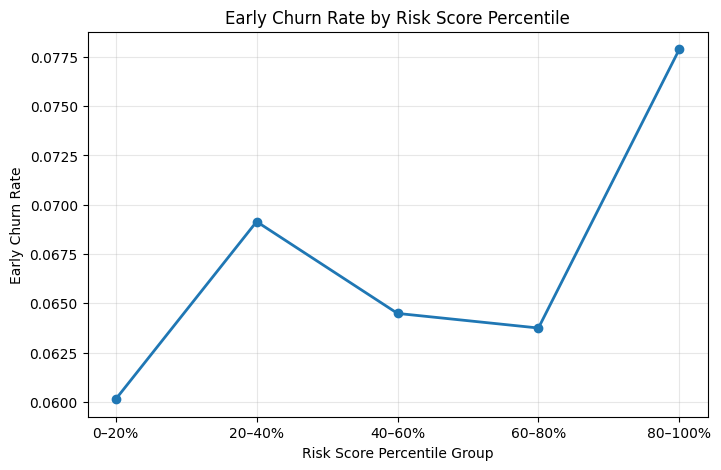

In [33]:
import matplotlib.pyplot as plt

# Percentile bin 만들기 (5분위)
risk_df['risk_bin'] = pd.qcut(
    risk_df['risk_percentile'],
    q=5,
    labels=['0–20%', '20–40%', '40–60%', '60–80%', '80–100%']
)

# 각 bin별 Early Churn 비율
churn_by_bin = (
    risk_df
    .assign(is_early_churn = risk_df['customer_group'] == 'Early Churn')
    .groupby('risk_bin')['is_early_churn']
    .mean()
)

plt.figure(figsize=(8,5))
plt.plot(churn_by_bin.index, churn_by_bin.values, marker='o', linewidth=2)

plt.title('Early Churn Rate by Risk Score Percentile', fontsize=12)
plt.xlabel('Risk Score Percentile Group')
plt.ylabel('Early Churn Rate')

plt.grid(True, alpha=0.3)
plt.show()


The chart shows a gradual increase in early churn rates as customer risk score percentiles rise. 
While differences are moderate in absolute terms, the consistent upward trend reinforces the interpretation of the risk score as a relative prioritization tool rather than a binary churn predictor.


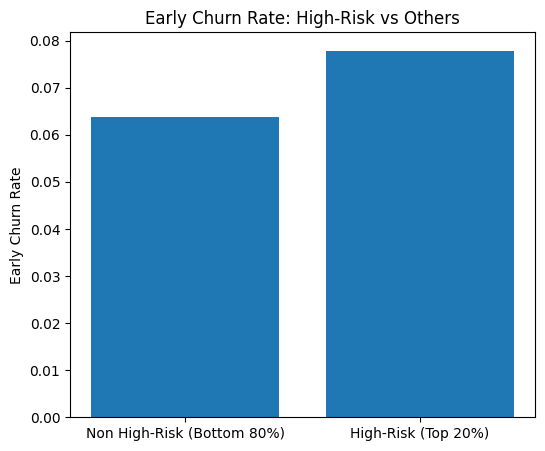

In [34]:
churn_compare = (
    risk_df
    .assign(is_early_churn = risk_df['customer_group'] == 'Early Churn')
    .groupby('top_risk_20')['is_early_churn']
    .mean()
)

plt.figure(figsize=(6,5))
plt.bar(
    ['Non High-Risk (Bottom 80%)', 'High-Risk (Top 20%)'],
    churn_compare.values
)

plt.title('Early Churn Rate: High-Risk vs Others', fontsize=12)
plt.ylabel('Early Churn Rate')

plt.show()


Customers classified as high-risk based on early support friction exhibit a higher early churn rate compared to the rest of the population. 
Although the difference is not extreme, it is directionally consistent and meaningful from a business prioritization perspective.
